In [12]:
# !pip install spacy
# !pip install nltk
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install sentence-transformers
# !pip install umap-learn

#run in terminal
# conda update conda
# conda install cython
# conda install hdbscan

In [4]:
#https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
from datetime import date
import spacy
from tqdm.notebook import tqdm
from spacy.tokenizer import Tokenizer
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ad_data = pd.read_csv('../libs/facebook_ad_Senate_v2.csv', low_memory=False)
print("Ads data shape : ", end = " ") ; print(ad_data.shape)

issue_data = pd.read_csv('../libs/facebook_ad_Senate_issues.csv',encoding = "ISO-8859-1", low_memory=False)
print("Issue data shape : ", end = " ")  ; print(issue_data.shape)

Ads data shape :  (1002439, 30)
Issue data shape :  (7058, 81)


In [3]:
#Removing nan values from the data 

ad_data.dropna(subset=['candidate'], inplace=True)
print("\n%s rows remaning after dropping 'nan' candidates"%(ad_data.shape[0]))


48087 rows remaning after dropping 'nan' candidates


In [4]:
#checking for empty values in other columns
ad_data[['funding_entity','ad_body_text','ad_link_caption','ad_link_description','ad_link_title','impressions_upper']].isna().sum()

funding_entity           456
ad_body_text             309
ad_link_caption         8984
ad_link_description    13373
ad_link_title           9041
impressions_upper        106
dtype: int64

In [5]:
ad_data.head()

id          state         candidate       party  \
0  1.008560e+14        Montana        Jon Tester  Democratic   
1  1.019970e+14  Massachusetts  Elizabeth Warren  Democratic   
2  1.026676e+14        Arizona    Kyrsten Sinema  Democratic   
3  1.031106e+14          Texas     Beto O'Rourke  Democratic   
4  1.035633e+14  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results  vote_pct ad_start_time  \
0            Tossup   Incumbent          Won      0.50     5/15/2018   
1  Solid Democratic   Incumbent          Won      0.60     5/20/2018   
2            Tossup        Open          Won      0.50     5/22/2018   
3            Tossup  Challenger         Lost      0.48     9/27/2018   
4  Solid Democratic   Incumbent          Won      0.60     9/28/2018   

  ad_stop_time  ...  impressions_upper  male female age18_24 age25_34  \
0    5/17/2018  ...            14999.0  0.40   0.60     0.06     0.16   
1    5/21/2018  ...             1999.0  1.00   0.00     0.00     0.00   
2    5/31/2018  ...              999.0  0.35   0.64     0.07     0.10   
3    9/27/2018  ...             1999.0  0.39   0.61     0.74     0.25   
4    9/30/2018  ...             5999.0  0.24   0.75     0.00     0.00   

  age35_44 age45_54  age55_64  age65plus  \
0     0.18     0.17      0.21       0.22   
1     0.00     0.00      1.00       0.00   
2     0.12     0.17      0.27       0.25   
3     0.00     0.00      0.00       0.00   
4     0.00     0.19      0.43       0.37   

                                     ad_snapshot_url  
0  https://www.facebook.com/ads/archive/render_ad...  
1  https://www.facebook.com/ads/archive/render_ad...  
2  https://www.facebook.com/ads/archive/render_ad...  
3  https://www.facebook.com/ads/archive/render_ad...  
4  https://www.facebook.com/ads/archive/render_ad...  

[5 rows x 30 columns]

In [6]:
issue_data.head()

id          state         candidate       party  \
0  1.008560e+14        Montana        Jon Tester  Democratic   
1  1.019970e+14  Massachusetts  Elizabeth Warren  Democratic   
2  1.026680e+14        Arizona    Kyrsten Sinema  Democratic   
3  1.031110e+14          Texas     Beto O'Rourke  Democratic   
4  1.035630e+14  Massachusetts  Elizabeth Warren  Democratic   

    competitiveness      status vote_results  vote_pct ad_start_time  \
0            Tossup   Incumbent          Won      0.50     5/15/2018   
1  Solid Democratic   Incumbent          Won      0.60     5/20/2018   
2            Tossup        Open          Won      0.50     5/22/2018   
3            Tossup  Challenger         Lost      0.48     9/27/2018   
4  Solid Democratic   Incumbent          Won      0.60     9/28/2018   

  ad_stop_time  ...  issue_immigration issue_terrorism issue_nuclear  \
0    5/17/2018  ...                  0               0             0   
1    5/21/2018  ...                  0               0             0   
2    5/31/2018  ...                  0               0             0   
3    9/27/2018  ...                  0               0             0   
4    9/30/2018  ...                  0               0             0   

  issue_iran issue_china issue_nkorea issue_russia  issue_mexico  issue_meast  \
0          0           0            0            0             0            0   
1          0           0            0            0             0            0   
2          0           0            0            0             0            0   
3          0           0            0            0             0            0   
4          0           0            0            0             0            0   

   money_politics  
0               0  
1               0  
2               0  
3               0  
4               1  

[5 rows x 81 columns]

In [7]:
issue_data.columns

Index(['id', 'state', 'candidate', 'party', 'competitiveness', 'status',
       'vote_results', 'vote_pct', 'ad_start_time', 'ad_stop_time', 'page_id',
       'page_name', 'funding_entity', 'ad_body_text', 'ad_link_caption',
       'ad_link_description', 'ad_link_title', 'spend_lower', 'spend_upper',
       'impressions_lower', 'impressions_upper', 'male', 'female', 'age18_24',
       'age25_34', 'age35_44', 'age45_54', 'age55_64', 'age65plus',
       'ad_snapshot_url', 'issue_content', 'issue_economy', 'issue_tax',
       'issue_business', 'issue_jobs', 'issue_income', 'issue_housing',
       'issue_spending', 'issue_trade', 'issue_infrastructure',
       'issue_farming', 'issue_energy', 'issue_drilling', 'issue_environment',
       'issue_disaster', 'issue_lands', 'issue_tourism', 'issue_abortion',
       'issue_race', 'issue_gender', 'issue_violence', 'issue_assault',
       'issue_guns', 'issue_lgbt', 'issue_healthcare', 'issue_opioid',
       'issue_education', 'issue_leave', 'iss

In [8]:
candidate_name = np.sort(list(ad_data.candidate.unique()))
candidate_name

array(['Amy Klobuchar', 'Angus King', 'Ben Cardin', 'Bernie Sanders',
       "Beto O'Rourke", 'Bill Nelson', 'Bob Casey Jr.', 'Bob Flanders',
       'Bob Hugin', 'Bob Menendez', 'Chele Farley', 'Chris Murphy',
       'Cindy Hyde-Smith', 'Claire McCaskill', 'Corey Stewart',
       'David Baria', 'Dean Heller', 'Deb Fischer', 'Debbie Stabenow',
       'Dianne Feinstein', 'Elizabeth Warren', 'Eric Brakey',
       'Gary Johnson', 'Gary Trauner', 'Geoff Diehl', 'Heidi Heitkamp',
       'Jacky Rosen', 'Jane Raybould', 'Jenny Wilson', 'Jim Newberger',
       'Jim Renacci', 'Joe Donnelly', 'Joe Manchin', 'John Barrasso',
       'John James', 'Jon Tester', 'Josh Hawley', 'Karin Housley',
       'Kevin Cramer', 'Kevin de León', 'Kirsten Gillibrand',
       'Kyrsten Sinema', 'Lawrence Zupan', 'Leah Vukmir', 'Lou Barletta',
       'Maria Cantwell', 'Marsha Blackburn', 'Martha McSally',
       'Martin Heinrich', 'Matt Rosendale', 'Matthew Corey',
       'Mazie Hirono', 'Mick Rich', 'Mike Braun', 'M

## Runtime Duration 

In [9]:
def duration_calc(f_date, l_date):
    f_date = [int(x) for x in f_date.split("/")]
    l_date = [int(x) for x in l_date.split("/")]
    delta = date(l_date[2],l_date[0],l_date[1]) - date(f_date[2],f_date[0],f_date[1])
    return delta.days

In [10]:
ad_data['runtime_days'] = ad_data.apply(lambda row: duration_calc(row.ad_start_time,row.ad_stop_time)+1, axis = 1)

## Labelled Issues

In [11]:
#reading primary and secondary issues
issue_ref = pd.read_csv("../libs/issue_ref.csv")
issue_ref

main_issues  \
0                              Economic   
1                                Social   
2                        Social Welfare   
3                         Law and Order   
4  National security and Foreign policy   
5                                 Other   

                                          sub_issues  
0   ["issue_economy" "issue_tax" "issue_business"...  
1   ["issue_abortion" "issue_race" "issue_gender"...  
2   ["issue_healthcare" "issue_opioid" "issue_edu...  
3   ["issue_crime" "issue_police" "issue_drugs" "...  
4   ["issue_military" "issue_defense" "issue_immi...  
5                                 ["money_politics"]

In [12]:
def issue_label(df):
    shape_df = df.shape
    col_list = list(df.columns)
    issues_list = re.findall(r'\bissue_[a-z]*\b'," ".join(col_list))
    issue_names = []
    issues = []
    issues_count = np.zeros(len(issues_list))
    for i in tqdm(range(shape_df[0])):
        local_issue = []
        for j in range(len(issues_list)):
            if df[issues_list[j]][i] == 1 and issues_list[j] != "issue_content":
                local_issue.append(issues_list[j].strip("issue_"))
                issues_count[issues_list.index(issues_list[j])] += 1
        issues.append(local_issue) 
        
    df["Issues"] = issues  
    return df , issues_list, issues_count

In [13]:
df, issue, cnt =  issue_label(issue_data)

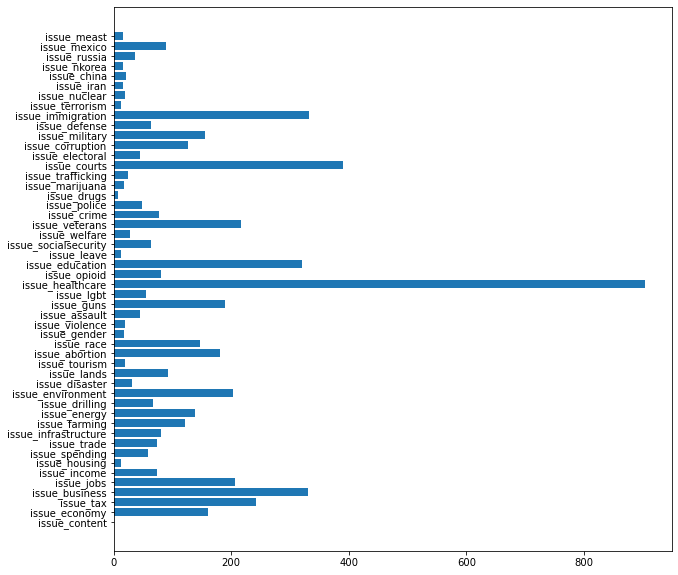

In [14]:
plt.figure(figsize=(10,10))
plt.barh(issue,cnt)
plt.show()

## BERT

### Data Pre-processing

In [15]:
# Considering only the text data in the ads
ad_text = ad_data['ad_body_text'].unique()

In [16]:
state_names = ad_data.state.unique()
state_names = [i.lower() for i in state_names]

candidate_names = [i.lower() for i in ad_data.candidate.unique()]
candidate_names = candidate_names + ([i.split(' ')[1] for i in candidate_names])
candidate_names = candidate_names + ([i.split(' ')[0] for i in candidate_names])
candidate_names = list(set(candidate_names))
candidate_names.append("trump")
#generating regex of the state and candidate names 
state_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, state_names)))
candidate_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, candidate_names)))

In [17]:
def bert_preprocess(text):
    text = str(text).lower()
    text = state_regex.sub('', text)
    text = candidate_regex.sub('', text)
    text = re.sub(r'\bhttp[s]?:[\w\W]+\b','link',text)
    text = re.sub(r'\b[a-zA-Z\.]+.com/[a-zA-Z]+\b','link',text)
    text = re.sub(r'[^A-Za-z0-9 ]+ ', ' ', text)
    text = re.sub(r'\d+\w+','',text)
    return text

In [18]:
#pre-processing all text 
# --> Converting to lower case 
# --> Removing any state or candidate name (if any)
# --> Replacing any URLs (if any) by "link" keyword

docs_2 = [bert_preprocess(i) for i in tqdm(ad_text)]

In [19]:
def manual_topic(text_df, topic_list):
    for topic in topic_list:
        text_df["t_"+topic] = text_df.apply(lambda row: topic in row.text, axis = 1)
    return text_df

In [20]:
doc2_df = pd.DataFrame(docs_2, columns=["text"])
# doc2_df.head() 
topic_list = ["health","tax","economy","abortion","military","guns","environment"]

doc2_df = manual_topic(doc2_df,topic_list)
doc2_df.head(10)

text  t_health  t_tax  \
0  i’m leading a bipartisan coalition of business...     False  False   
1  the bank lobbyists have a dodd-frank rollback ...     False  False   
2  do you think politicians should be able to mak...      True  False   
3  come meet congressman   at ut arlington and re...     False  False   
4  brett kavanaugh has shown us that it’s more im...     False  False   
5  breaking our race moved from lean republican t...     False  False   
6  are you  sure you’re ready to vote on election...     False  False   
7  brett kavanaugh’s testimony made one thing ver...     False  False   
8  tennesseans want their next u.s senator to hav...     False  False   
9  we must end republican control of the senate a...     False  False   

   t_economy  t_abortion  t_military  t_guns  t_environment  
0      False       False       False   False          False  
1      False       False       False   False          False  
2      False       False       False   False          False  
3      False       False       False   False          False  
4      False       False       False   False          False  
5      False       False       False   False          False  
6      False       False       False   False          False  
7      False       False       False   False          False  
8      False       False       False   False          False  
9      False       False       False   False          False

#### Generating embeddings for Ads using SentenceTransformers

In [89]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(docs_2, show_progress_bar=True)
print(f"Embeddings generated !\nOutput shape : {np.shape(embeddings)}")


Embeddings generated !
Output shape : (7069, 768)


#### Dimensionality reduction using UMAP for clustering

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

print(f"UMAP embeddings generated !\nOutput shape : {np.shape(umap_embeddings)}")

#### Clustering using HBDSCAN 

In [128]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
print(f"Clustering finished !\nNo. of clusters generated : {len(np.unique(cluster.labels_))}")

Clustering finished !
No. of clusters generated : 123


In [129]:
plt.hist(list(cluster.labels_), bins = len(np.unique(cluster.labels_)))
plt.show()

#### Assigning clusters to the text

In [101]:
docs_df = pd.DataFrame(docs_2, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

# joining all the texts unders the same topic to make large single text
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [102]:
docs_df.head()

Doc  Topic  Doc_ID
0  i’m leading a bipartisan coalition of business...     11       0
1  the bank lobbyists have a dodd-frank rollback ...     11       1
2  do you think politicians should be able to mak...     11       2
3  come meet congressman   at ut arlington and re...     11       3
4  brett kavanaugh has shown us that it’s more im...     11       4

In [39]:
docs_per_topic.head()

Topic                                                Doc
0     -1  the bank lobbyists have a dodd-frank rollback ...
1      0  i'm investing in broadband and infrastructure ...
2      1  come meet 's mom and sister melissa and charlo...
3      2    is running for u.s senate to break through t...
4      3  tell us where to send your free limited-editio...

#### Calculating TF-IDF for each cluster to identify topics 

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs_2))

#### Extracting top 20 words 

In [30]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

Topic  Size
0      -1  3663
35     34   299
38     37   236
48     47   221
34     33   188
59     58   154
60     59   152
7       6   127
26     25   101
47     46    92

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(docs_2)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

Topic  Size
0      -1  3782
21     20   335
31     30   245
24     23   236
20     19   207
39     38   188
40     39   171
5       4   127
11     10   121
14     13   101

In [58]:
top_n_words[20][:10]

[('vote', 0.13457744859146137),
 ('early', 0.08889045751640984),
 ('voting', 0.08620614013550734),
 ('polling', 0.08159425154574919),
 ('day', 0.06383289589050004),
 ('election', 0.06258675980290158),
 ('place', 0.05631152571467197),
 ('make', 0.054512893860235605),
 ('plan', 0.047718924331502786),
 ('ballot', 0.047709234832304555)]

In [60]:
top_n_words[30][:10]      #Fundraising

[('senate', 0.03737871072313934),
 ('race', 0.031208388188345773),
 ('donors', 0.03051233022726427),
 ('opponent', 0.029629066412833093),
 ('million', 0.029182055970831317),
 ('spending', 0.028780781324817546),
 ('help', 0.02851674184755371),
 ('right', 0.02716695481912914),
 ('money', 0.026907614450630113),
 ('win', 0.02629004482891766)]

In [61]:
top_n_words[23][:10]    #Notification of event

[('join', 0.04306243766235722),
 ('hall', 0.03854674505010122),
 ('town', 0.038519979769581304),
 ('rsvp', 0.036957915262607804),
 ('debate', 0.03660607768855462),
 ('friday', 0.032597519970585),
 ('fe', 0.030254247423642053),
 ('pm', 0.028555796675231),
 ('county', 0.026841562405572734),
 ('september', 0.025326668822433722)]

In [63]:
top_n_words[19][:10]      #Rally invite

[('deadline', 0.06249666039776689),
 ('election', 0.04248130771706973),
 ('fundraising', 0.04111732225730025),
 ('goal', 0.04092414197742306),
 ('final', 0.040749278879957065),
 ('midnight', 0.03990027021554298),
 ('chip', 0.03912769758197077),
 ('help', 0.03462705557211167),
 ('campaign', 0.0343864323588904),
 ('contribution', 0.03385561492165021)]

In [64]:
top_n_words[38][:10]     #Infrastructures 

[('veterans', 0.05081325876498766),
 ('rural', 0.036828348386369225),
 ('communities', 0.03619025798770314),
 ('investing', 0.03469413075766929),
 ('businesses', 0.02993515066143444),
 ('care', 0.02945005802104404),
 ('boost', 0.029073492658204084),
 ('economy', 0.029069615052491476),
 ('support', 0.02797333798080938),
 ('continue', 0.02730822190776)]

In [96]:
top_n_words[20][:10]  #

[('supporters', 0.09577416126686743),
 ('fellow', 0.08573295517300163),
 ('area', 0.0636853067895174),
 ('person', 0.06325881694700264),
 ('join', 0.06007360440678541),
 ('volunteers', 0.058092012619371525),
 ('steps', 0.056993620160158125),
 ('specific', 0.056233059586682246),
 ('leave', 0.0547403955489238),
 ('organizing', 0.04759057769424755)]

In [97]:
top_n_words[13][:10] #Spanish community

[('para', 0.15551706842710264),
 ('te', 0.14175309960185337),
 ('en', 0.10359119003951292),
 ('candidatura', 0.09855157676744276),
 ('detalles', 0.09834164367002732),
 ('quiere', 0.09833259589644186),
 ('sobre', 0.09799935996872933),
 ('compartir', 0.0975249978427819),
 ('conocer', 0.09711946539720406),
 ('acompaña', 0.0969564811924272)]

In [98]:
top_n_words[35][:10]  #DJT Bdy

[('president', 0.18942902850062643),
 ('birthday', 0.13489280891495786),
 ('trump', 0.13464014370025898),
 ('card', 0.10450166942553722),
 ('happy', 0.07766555664800605),
 ('donald', 0.07097766933036832),
 ('peace', 0.06815326266882862),
 ('sign', 0.052813061066542044),
 ('vice', 0.05063966368142319),
 ('wishing', 0.04568372231980551)]

In [99]:
top_n_words[29][:10]    #TAXES

[('tax', 0.12445953637388485),
 ('taxes', 0.07559069284598048),
 ('hikes', 0.047767072429294004),
 ('increases', 0.04027452521244162),
 ('reckless', 0.038236635679135024),
 ('patients', 0.038236635679135024),
 ('relief', 0.03760183880530017),
 ('cancer', 0.03393433861327642),
 ('bankrupt', 0.03346323762596503),
 ('drug', 0.03299211304081495)]

In [101]:
top_n_words[-1]

[('senate', 0.015200627901325453),
 ('trump', 0.015185363042649462),
 ('people', 0.015169535151115382),
 ('help', 0.014743997801822116),
 ('link', 0.014670254088992371),
 ('need', 0.013951434043138538),
 ('vote', 0.013897998416427968),
 ('today', 0.013700753646670156),
 ('senator', 0.013216676437968047),
 ('make', 0.013098869530551826),
 ('fight', 0.012526964015242347),
 ('care', 0.012142570657234744),
 ('campaign', 0.012064113355421261),
 ('support', 0.011783584953786395),
 ('health', 0.011773847307198985),
 ('president', 0.01139451573968325),
 ('right', 0.011285259832079694),
 ('time', 0.010952161318947991),
 ('fighting', 0.010867833874564244),
 ('like', 0.010796772747463825)]

In [115]:
top_n_words[14][:10] #ENERGY

[('energy', 0.4177734158409685),
 ('renewable', 0.20186675590575995),
 ('credits', 0.20072035125224164),
 ('brokered', 0.1873389945020922),
 ('deal', 0.16347804471068136),
 ('county', 0.16164955843753614),
 ('producers', 0.1530715312856599),
 ('oil', 0.13310280496897542),
 ('powering', 0.12650045934859405),
 ('tax', 0.12021921859863774)]

In [116]:
top_n_words[15][:10] #IMMIGRATION
top_n_words[28][:10] 

[('border', 0.1426993350643529),
 ('illegal', 0.13496108373779073),
 ('immigration', 0.09446397203349113),
 ('borders', 0.07901519028526698),
 ('cities', 0.07385591302434363),
 ('sanctuary', 0.06400350378542388),
 ('security', 0.062331804952825066),
 ('law', 0.0567497044508212),
 ('secure', 0.055944418408213965),
 ('safe', 0.052829148786534066)]

In [124]:
top_n_words[23][:10]   #College tuition jobs

[('jobs', 0.06089248767400025),
 ('candidates', 0.05709332554925426),
 ('support', 0.04528953718087121),
 ('economy', 0.04223731553474952),
 ('ideas', 0.04163544773950258),
 ('transform', 0.03758955686494551),
 ('colleges', 0.03731965938051407),
 ('progressive', 0.03628885791700163),
 ('tuition', 0.03587294137578493),
 ('donation', 0.032758937162278096)]

In [125]:
top_n_words[24][:10]    # Anti trump

[('trump', 0.07145082252750062),
 ('dangerous', 0.058675797940738905),
 ('immigrants', 0.054523478976745476),
 ('slip', 0.05387184596069583),
 ('slash', 0.0486118604858771),
 ('roll', 0.04653105147187824),
 ('lgbtq', 0.0462212329149326),
 ('regulations', 0.04599148842490929),
 ('environmental', 0.043972616986713786),
 ('agenda', 0.04181732136604208)]

In [129]:
top_n_words[28][:10] 

[('immigration', 0.0672961998154304),
 ('border', 0.040214044471481164),
 ('america', 0.040002523150751916),
 ('president', 0.03737059547046154),
 ('cindy', 0.03647971811827185),
 ('senator', 0.03365275253454576),
 ('trump', 0.03274001609299417),
 ('illegal', 0.032337518021998655),
 ('taxes', 0.032183633975769003),
 ('secure', 0.030845885738741915)]

In [134]:
top_n_words[33][:10] #Voting

[('vote', 0.21313162841516328),
 ('polling', 0.14332679500796336),
 ('early', 0.10483370642412965),
 ('voting', 0.10361311152553469),
 ('election', 0.09530698732070135),
 ('day', 0.08736413500083944),
 ('location', 0.08493581957508724),
 ('absentee', 0.08320667365452906),
 ('today', 0.08148508081836513),
 ('place', 0.07166339750398168)]

In [140]:
top_n_words[38][:10]    #Foreign 

[('trump', 0.09104346134147034),
 ('mueller', 0.05972211944374632),
 ('putin', 0.057809723366611984),
 ('court', 0.057502191788771174),
 ('president', 0.05587962883272113),
 ('supreme', 0.05430924647605895),
 ('investigation', 0.052704373001154964),
 ('donald', 0.0464635002501399),
 ('russia', 0.043693765075957736),
 ('robert', 0.03853981557774132)]

In [141]:
top_n_words[39][:10]    #Healthcare  

[('insurance', 0.06979578938092316),
 ('existing', 0.06355083544095153),
 ('pre', 0.06338614317998793),
 ('care', 0.04836505947276437),
 ('condition', 0.046153259435975494),
 ('illness', 0.0438737857690698),
 ('coverage', 0.0397572207116612),
 ('health', 0.039302264298628264),
 ('plant', 0.03877778918452209),
 ('conditions', 0.035894490151130796)]

In [146]:
topic_sizes

Topic  Size
0      -1  4260
31     30   187
27     26   184
35     34   178
6       5   144
46     45   113
21     20   103
14     13   101
36     35    97
30     29    76
9       8    67
29     28    67
43     42    62
11     10    61
7       6    61
40     39    60
5       4    55
23     22    54
24     23    53
16     15    52
17     16    52
1       0    52
33     32    51
34     33    48
25     24    48
32     31    47
26     25    47
42     41    46
18     17    44
10      9    42
41     40    39
38     37    39
39     38    39
8       7    38
12     11    38
20     19    37
19     18    35
22     21    35
45     44    32
44     43    30
4       3    29
2       1    29
28     27    28
15     14    28
37     36    28
13     12    27
3       2    26